In [3]:
from mphelper import ProcessWrapPool
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import itertools
import biodataplot.metaplot as bpm
from biodata.bigwig import BigWigIReader
from biodata.bed import BEDXReader
from genomictools import GenomicCollection
from biodatatools.utils.common import json_dump
from commandtemplate.conda import run_template_bash
import seaborn as sns
import sys
from pathlib import Path

In [4]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [5]:
sys.path.append(f"{Path.cwd().parent}")
import utils

In [6]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

# Generate feature matrix

## Get individual matrix

In [7]:
s = "HCT116"
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]
cs = ["", "_control"]
gs = [f"{p}_{d}{c}" for p, d, c in itertools.product(ps, ds, cs)]

In [8]:
bws = {"CTCF": f"{PROJECT_DIR_r}ENCODE/ENCFF388PVO.bigWig",
	   "RAD21": f"{PROJECT_DIR_r}ENCODE/ENCFF776IXR.bigWig"
		}
ms = list(bws.keys())

In [9]:
df_features = {}
for g in gs:
	bed = f"{PROJECT_DIR_d}bed_plot/{s}_{g}.bed"
	if "control" in bed:
		all_regions = BEDXReader.read_all(GenomicCollection, bed)
		use_strand = False
	else:
		all_regions = BEDXReader.read_all(GenomicCollection, bed, strandfield="f7")
		use_strand = True
	index = [f"{r.chrom}_{r.chromStart}_{r.chromEnd}" for r in all_regions]

	for m in bws:
		df_features[(m,g)] = pd.DataFrame(bpm.generate_signal_profile(all_regions, BigWigIReader(bws[m]), fixed_size=1001, use_strand=use_strand), index=index)

In [10]:
df_reformat = {}
for k in df_features:
	df = df_features[k].reset_index()
	df_reformat[k] = pd.melt(df,
						  id_vars="index",
						  value_vars=list(df.columns[1:]),
						  var_name="Position",
						  value_name="Feature"
						  )

## Combine dataframes for plotting

In [11]:
df_metaplots = {}
for m, d in itertools.product(ms, ds):
	dfs = []
	for p in ps:
		df1 = df_reformat[(m, f"{p}_{d}")].copy()
		df2 = df_reformat[(m, f"{p}_{d}_control")].copy()
		df1["Label"] = p.capitalize()
		df2["Label"] = "Ctrl"
		dfs.extend([df1, df2])
	df_metaplots[(m,d)] = pd.concat(dfs).reset_index(drop=True)		

# Divergent vs. unidirectional

## Settings

### ylims

In [11]:
def get_ylims(labels, df_metaplots):
	for m, d in itertools.product(ms, ds):
		maxs = []
		mins = []
		df = df_metaplots[(m,d)]
		for label in labels:
			maxs.append(df[df["Label"]==label].groupby("Position")["Feature"].mean().max())
			mins.append(df[df["Label"]==label].groupby("Position")["Feature"].mean().min())
		print(d, m, max(maxs), min(mins))

In [12]:
labels = ["Ctrl", "Divergent", "Unidirectional"]
get_ylims(labels, df_metaplots)

distal CTCF 30.217921956404272 0.6891254908994491
proximal CTCF 25.881199419618614 0.6986522180567037
distal RAD21 4.189623356226407 0.4956126477579581
proximal RAD21 2.735267164125558 0.4469265057755414


### Sorting order

In [13]:
m = "CTCF"
sort_dict = {}
for g in gs:
	row_sums = df_features[(m, g)].sum(axis=1).to_dict()
	sort_dict.update({str(key): value for key, value in row_sums.items()})

In [14]:
json_dump(f"{PROJECT_DIR_o}labels/{s}_{m}_sum.json", sort_dict)

## Generate metaplots & heatmaps

In [12]:
def generate_metaplot_and_heatmap(d, ps, ms, df_metaplots, df_heatmaps, sort_file, ylims, yticks, cmap, outputfile, test, xlabel="Distance (kb)"):
	height_ratios = [5,5,5,0.8,1]
	fig, axes = plt.subplots(len(height_ratios), len(ms), figsize=(3.5, 5), gridspec_kw={'height_ratios': height_ratios})
	for col in range(len(ms)):
		axes[3,col].axis("off")
	labelpad = 2
	y_align = -0.25
	wspace = 0.3
	hspace = 0.3

	hue_order = ["Ctrl", "Divergent", "Unidirectional"]
	palette = ["#d9d9d9", "#313695", "#de77ae"]
	
	for m in ms:
		col = ms.index(m)
		for row in range(3):
			ax = axes[row, col]
			# Metaplot
			if row == 0:
				utils.generate_feature_metaplot(df_metaplots[(m,d)], palette, hue_order, ax, test)
				
				ax.set_ylim(ylims[ms.index(m)])
				ax.set_yticks(yticks[ms.index(m)])
				if col == 0:
					ax.set_ylabel("ChIP-seq", fontsize=bfontsize)
					ax.get_yaxis().set_label_coords(y_align, 0.5)
				else:
					ax.set_ylabel("")

				if col == 0:
					ax.legend(loc="upper center", bbox_to_anchor=(1.1, 1.6), ncol=len(hue_order), fontsize=sfontsize)
				else:
					ax.legend([],[], frameon=False)
					
			# Heatmap
			else:
				if row == 2:
					cbar = True
					cbar_ax = axes[4, col]
				else:
					cbar = False
					cbar_ax = None		
				cbar_kws = {"ticks": yticks[ms.index(m)], "orientation": "horizontal"}

				utils.generate_feature_heatmap(df_heatmaps[(m,f"{ps[row-1]}_{d}")], yticks[ms.index(m)], cmap, cbar, cbar_ax, cbar_kws, ax, sort_file, test)
				
				if row == 2:
					cbar_ax.set_xticklabels(yticks[ms.index(m)])
					cbar_ax.tick_params(axis="x", labelsize=sfontsize, pad=labelpad)

				if col == 0:
					tot = len(df_heatmaps[(m,f"{ps[row-1]}_{d}")])
					ylabel = f"{hue_order[row]}\n(n={tot})"
					ax.set_ylabel(ylabel, fontsize=bfontsize)
					ax.get_yaxis().set_label_coords(y_align/3, 0.5)
				else:
					ax.set_ylabel("")
				
			if row == 0:
				ax.set_title(m, fontsize=bfontsize, pad=5)
		
			xtick_list = [0,500,1000]
			xticklabel_list = ["-0.5", "0", "0.5"]
			ax.set_xlim([0, 1000])
			ax.set_xticks(xtick_list)
			if row == 2:
				ax.set_xticklabels(xticklabel_list)
				ax.set_xlabel(xlabel, fontsize=bfontsize)
			else:
				ax.set_xticklabels([])
				ax.set_xlabel("")

			ax.tick_params(labelsize=sfontsize, pad=labelpad)

	fig.subplots_adjust(wspace=wspace, hspace=hspace)
	plt.savefig(outputfile, bbox_inches="tight", dpi=300, transparent=True) 

In [16]:
pwpool = ProcessWrapPool(len(ds))

# test = True
test = False
cmap = "viridis"
sort_file = f"{PROJECT_DIR_o}labels/{s}_CTCF_sum.json"
for d in ds:
	if d == "distal":
		ylims = [[-5, 35], [-0.5, 5.0]]
		yticks = [[0, 10, 20, 30], [0, 1.5, 3.0, 4.5]]
	else:
		ylims = [[-3, 33], [-0.5, 3.5]]
		yticks = [[0, 10, 20, 30], [0, 1, 2, 3]]
	folder = "figures/" if d == "distal" else "other_figures/"
	outputfile = f"{PROJECT_DIR_o}{folder}ExtDataFig8a.png"
	pwpool.run(generate_metaplot_and_heatmap, args=[d, ps, ms, df_metaplots, df_features, sort_file, ylims, yticks, cmap, outputfile, test])

In [18]:
len(pwpool.finished_tasks)

2

In [19]:
pwpool.close()

# Divergent DIs

In [13]:
p = "divergent"

## Get DI quantiles

In [ ]:
files = [f"{PROJECT_DIR_d}bed_plot/{s}_{p}_{d}.bed" for d in ds]
clsname = " ".join([f"{p}_{d}" for d in ds])
filestr = " ".join(["{i" + str(idx) + "}" for idx in range(len(files))])
run_template_bash(
	"biodatatools annotate_bed_classes -i " + filestr + " -clsname {clsname} -column 3 -o - | cut -f 1-4 | biodatatools annotate_bed_directionality_index -i - -ipl {ipl} -imn {imn} -o {o}",
	conda_env="DI",
	**{f"i{idx}": file for idx, file in enumerate(files)},
	ipl=f"{PROJECT_DIR_d}Alignments/brm_CTCF_U1_and_CTCF_U2_erm_5pl.bw",
	imn=f"{PROJECT_DIR_d}Alignments/brm_CTCF_U1_and_CTCF_U2_erm_5mn.bw",
	clsname=clsname,
	o=f"{PROJECT_DIR_d}bed_plot/{s}_DI.bed"
)

In [14]:
inputfile = f"{PROJECT_DIR_d}bed_plot/{s}_DI.bed"
df_DI = pd.read_table(inputfile, header=None)
df_DI.columns = ["chrom", "start", "end", "group", "DI"]
df_DI.head(2)

,chrom,start,end,group,DI
0,chr1,904521,905022,divergent_proximal,-0.101147
1,chr1,924751,925252,divergent_proximal,-0.150160


In [35]:
qs = ["Q1", "Q2", "Q3", "Q4"]
palette = ["#9ecae1", "#4292c6", "#807dba", "#3f007d"]

In [16]:
# Get quantiles based on absolute DIs for distal and proximal separately

df_quantiles = {}
for d in ds:
	df2 = df_DI[df_DI["group"].str.contains(d)].copy()
	df2["|DI|"] = df_DI["DI"].abs()
	df2["quantile"] = pd.qcut(df2["|DI|"], q=4, labels=qs)
	df_quantiles[d] = df2

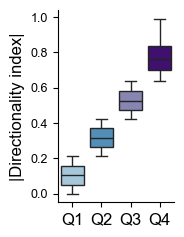

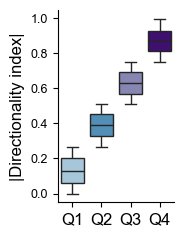

In [36]:
for d in ds:
	fig, ax = plt.subplots(figsize=(1.5,2.5))
	g = sns.boxplot(data=df_quantiles[d], x="quantile", y="|DI|", 
					order=qs, hue="quantile", palette=palette, legend=False, ax=ax
				   )
	g.spines[["right", "top"]].set_visible(False)

	g.set_ylabel("|Directionality index|", fontsize=bfontsize)
	g.tick_params(axis="y", labelsize=sfontsize)
	
	g.set_xlabel("")
	g.tick_params(axis="x", labelsize=bfontsize)

	folder = "figures/" if d == "distal" else "other_figures/"
	outputfile = f"{PROJECT_DIR_o}{folder}ExtDataFig8b.left.pdf"
	plt.savefig(outputfile, bbox_inches="tight", transparent=True)

In [18]:
quantile_dict = {}
for d in ds:
	for index, row in df_quantiles[d].iterrows():
		quantile_dict[f"{row['chrom']}_{row['start']}_{row['end']}"] = row["quantile"]

In [27]:
json_dump(f"{PROJECT_DIR_o}labels/{s}_DI.json", quantile_dict)

In [19]:
df_metaplots2 = {}
for m, d in itertools.product(ms, ds):
	df = df_reformat[(m, f"{p}_{d}")].copy()
	df["Label"] = df["index"].map(quantile_dict)
	df_metaplots2[(m,d)] = df

## Generate metaplots

### ylims

In [29]:
get_ylims(qs, df_metaplots2)

distal CTCF 12.883546151974748 1.161658167003305
proximal CTCF 10.259398956439618 1.647304787153571
distal RAD21 1.9849783308021636 0.5938014709437377
proximal RAD21 1.1166520705185146 0.531660910043054


### Metaplot

In [20]:
def generate_metaplot(d, ms, df_metaplots, ylims, yticks, outputfile, test, xlabel="Distance (kb)"):
	fig, axes = plt.subplots(1,len(ms),figsize=(4,2))
	labelpad = 6
	y_align = -0.2
	wspace = 0.3

	for m in ms:
		col = ms.index(m)
		ax = axes[col]
		utils.generate_feature_metaplot(df_metaplots[(m,d)], palette[::-1], qs[::-1], ax, test)
		
		ax.set_title(m, fontsize=bfontsize, pad=labelpad)
		if col == 0:
			ax.legend(loc="upper left", bbox_to_anchor=(0.58,1.03), fontsize=sfontsize, frameon=False,
					 handlelength=1.0, handletextpad=0.5, labelspacing=0.2)
		else:
			ax.legend([],[], frameon=False)
		
		ax.set_ylim(ylims[col])
		ax.set_yticks(yticks[col])
		if col == 0:
			ax.set_ylabel("ChIP-seq", fontsize=bfontsize)
			ax.get_yaxis().set_label_coords(y_align, 0.5)
		else:
			ax.set_ylabel("")
		
		xtick_list = [0,500,1000]
		xticklabel_list = ["-0.5", "0", "0.5"]
		ax.set_xlim([0, 1000])
		ax.set_xticks(xtick_list)
		ax.set_xticklabels(xticklabel_list)
		ax.set_xlabel(xlabel, fontsize=bfontsize)
		
		ax.tick_params(labelsize=sfontsize, pad=labelpad)

	fig.subplots_adjust(wspace=wspace)
	plt.savefig(outputfile, bbox_inches="tight", transparent=True) 

In [37]:
pwpool = ProcessWrapPool(len(ds))

# test = True
test = False
for d in ds:
	if d == "distal":
		ylims = [[-1,16], [0.5,2.3]]
		yticks = [[0,5,10,15], [0.7,1.4,2.1]]
	else:
		ylims = [[-1,13], [-0.2,1.4]]
		yticks = [[0,4,8,12], [0,0.4,0.8,1.2]]
	folder = "figures/" if d == "distal" else "other_figures/"
	outputfile = f"{PROJECT_DIR_o}{folder}ExtDataFig8b.right.pdf"
	pwpool.run(generate_metaplot, args=[d, ms, df_metaplots2, ylims, yticks, outputfile, test])

In [39]:
len(pwpool.finished_tasks)

2

In [40]:
pwpool.close()